In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import numpy as np
import pygmt
import pandas as pd
import xarray as xr
import sys
import datetime


In [4]:
sys.path.insert(0, '/home/catherinej/claw_tools/src/claw_tools/post')
sys.path.insert(0, '/home/catherinej/BarrierBreach/src/barrierbreach/')
import waveforms
import breach_randomization as br
                

In [5]:
# PATH = '/home/catherinej/BarrierBreach/data/m_gauges.csv'
gauge_locs = pd.read_csv('/home/catherinej/breach_study_setrun_inputs/moriches_bay_gauges.csv')
gauge_locs.iloc[135]

Unnamed: 0    135.000000
lon           -72.634870
lat            40.800420
depth          -0.141293
Name: 135, dtype: float64

In [6]:
gauge_locs = gauge_locs.rename(columns={'Unnamed: 0': 'GaugeName'})
gauge_locs

,GaugeName,lon,lat,depth
0,0,-72.884900,40.738300,1.667485
1,1,-72.842468,40.750054,1.500641
2,2,-72.804580,40.770500,2.301971
3,3,-72.804000,40.777800,2.187709
4,4,-72.784900,40.754200,5.105707
...,...,...,...,...
132,132,-72.846320,40.741520,1.757125
133,133,-72.752660,40.781300,2.586190
134,134,-72.744520,40.785550,1.144157
135,135,-72.634870,40.800420,-0.141293


In [5]:
sub_df = gauge_locs.iloc[[46, 72, 83, 133, 91, 103, 119]]
bay_gauges_df = waveforms.find_gauge_locations(PATH)


In [11]:
# bay_gauges_df = bay_gauges_df.drop([57, 58])
for gauge_no in bay_gauges_df.index.values:
    
    filename = f'/home/catherinej/BarrierBreach/data/simulations/no_breach/_output/gauge1{gauge_no:04}.txt'
    eta = np.genfromtxt(filename, skip_header=3, max_rows=1, usecols=[5])
    if eta > 0.001:
        print('dropped: ', gauge_no, eta)
        bay_gauges_df = bay_gauges_df.drop([gauge_no]) 

dropped:  69 0.7262492
dropped:  70 0.3409202
dropped:  71 2.078135
dropped:  73 0.5476931
dropped:  74 0.3711545
dropped:  75 1.065956
dropped:  86 1.6
dropped:  93 0.7796502
dropped:  97 2.72251
dropped:  109 0.2251308
dropped:  111 0.4557818
dropped:  113 0.5502666
dropped:  114 1.273609
dropped:  117 0.189465
dropped:  122 2.098067
dropped:  126 9.2621


In [8]:
bay_gauges_df.to_csv('/home/catherinej/BarrierBreach/data/bay_gauges.csv')

In [30]:
from clawpack.amrclaw import region_tools
file = '/home/catherinej/BarrierBreach/src/models/geoclaw_tools/moriches_RR2.data'
rr = region_tools.RuledRectangle(file)
rr.read(file)
# lines = open(file, 'r').readlines()
# k = -1
# comments=True
# while comments:
#     k +=1 
#     line = lines[k].strip()
#     if (line != '') and (line[0] != '#'):
#         comments=False
# ixy = int(line.split()[0])
# k +=1
# method = int(line.split()[0])
# k += 1
# ds = float(lines[k].split()[0])
# k +=1
# nrule = int(lines[k].split()[0])
# slu = np.loadtxt(file, skiprows=k+1)
# s = slu[:,0]
# lower = slu[:,1]
# upper = slu[:,2]
xv, yv = rr.vertices()

In [8]:
bay_gauges = pd.read_csv('/home/catherinej/BarrierBreach/data/bay_gauges.csv')
ocean_gauges = pd.read_csv('/home/catherinej/refactor_breach/geoclaw_input_data/ocean_gauges.csv')
def calc_min_distance(gauges, lon ,lat):
    gauges['Distance'] = [waveforms.calc_distance(lat, y, lon, x) for y, x in zip(gauges['lat'], gauges['lon'])]
    index = gauges.Distance.idxmin()
    return gauges.iloc[index]['GaugeNames']
breach_data_file = '/home/catherinej/BarrierBreach/data/simulations/d1/breach.data'

with open(breach_data_file) as f:
    data = f.read()
data = data.split('\n')
data = [line.split(' ') for line in data]
data.pop(0)
names = data.pop(0)
if not 'depth' in names:
    names.append('Depth')
d = {k: v for k,v in zip(names, data) if k != 'sigma,'}
df = pd.DataFrame(d)
df.columns = [col.replace(',', '') for col in df.columns]
df = df.apply(pd.to_numeric, errors='ignore')
df['lat'] = [(x + y )/2 for x,y in zip(df['south'], df['north'])]
df

nearest_bay = [calc_min_distance(bay_gauges, lon, lat) for lon, lat in 
                zip(df['mu'], df['lat'])]
nearest_ocean = [ocean_gauges.iloc[br.find_nearest_gauges(ocean_gauges, lon, lat, 1000).dist.idxmin()]['Unnamed: 0'] for lon, lat in
                zip(df['mu'], df['lat'])]


FileNotFoundError: [Errno 2] No such file or directory: '/home/catherinej/BarrierBreach/data/simulations/d1/breach.data'

In [18]:
nearest_bay = [104, 79]

In [19]:
bay_df = bay_gauges.loc[bay_gauges['GaugeNames'].isin(nearest_bay)]
ocean_df = ocean_gauges.loc[ocean_gauges['Unnamed: 0'].isin(nearest_ocean)]

In [20]:
# Create a map of moriches
bathy = '/home/catherinej/bathymetry/moriches.nc'
def gauge_locs_map():
    import yaml
    with open('/home/catherinej/claw_code/src/claw_code/post/gmt_config.yml', 'r') as ymlfile:
        cfg = yaml.safe_load(ymlfile)
    fig = pygmt.Figure()
    with pygmt.config(**cfg['region_map']):
        region = cfg['moriches_map']['region']
        frame_params = cfg['moriches_map']['basemap_frame']
        grid = '/home/catherinej/bathymetry/moriches_d1.nc'
        grd = pygmt.grdclip(grid=grid, below=[0.0, -50.0])
        fig.basemap(region=region, projection='M20c', frame=frame_params)
        pygmt.makecpt(cmap='gray', series=[-50,50], reverse=True)
        fig.grdimage(grid=grd, cmap=True, shading=True)
        fig.plot(x=bay_gauges_df.lon, y=bay_gauges_df.lat, color='red', style='c0.125c')
        fig.text(x=bay_df.lon+0.0035, y=bay_df.lat-0.0035, 
                 text=bay_df['GaugeNames'])
        # fig.plot(x=ocean_df.lon, y=ocean_df.lat, color='red', style='c0.125c')
        # fig.text(x=ocean_df.lon+0.0035, y=ocean_df.lat-0.0035, text=ocean_df['Unnamed: 0'])
        fig.savefig('/home/catherinej/BarrierBreach/visualization/nearest_gauges_map.pdf')

# grd = pygmt.datasets.load_earth_relief(region= [-72.88, -72.58, 40.68, 40.83],resolution='01s',)
# with pygmt.config(
#     FORMAT_GEO_MAP='ddd.xx'):
#     # [-72.88, -72.65, 40.72, 40.829]
#     fig.basemap(region=[-72.90, -72.65, 40.72, 40.83], projection='M25c', frame=True)

#     fig.plot(x=bay_gauges_df.lon, y=bay_gauges_df.lat, color='red', style='c0.125c')
#     fig.plot(x=-72.875,y=40.73, color='blue', style='c0.25c')
#     fig.plot(x=-72.67, y=40.788, color='blue', style='c0.25c')
#     fig.text(x=bay_gauges_df.lon+0.0035, y=bay_gauges_df.lat-0.0035, text=bay_gauges_df.index)
#     fig.plot(x=gauge_locs.iloc[46]['lon'], y=gauge_locs.iloc[46]['lat'], style='c0.125c', color='black')
#     fig.plot(x=bay_gauges_df.iloc[17]['lon'], y=bay_gauges_df.iloc[17]['lat'], style='c0.125c', color='green')
#     # fig.plot(x=xv, y=yv, color='red', pen='thin,red', transparency='50')
# # fig.grdcontour(grid=grd, annotation=5, interval="-5,", D='5m_moriches.data', limit=[-6,-4], label_placement='D50k')
#     # fig.plot(subset_df, color='orange', style='c0.25c')
#     # fig.text(x=subset_df.lon, y=subset_df.lat-0.0035, text=subset_df.index)
#     fig.coast(shorelines=True)
#     # fig.savefig('/home/catherinej/BarrierBreach/visualization/bay_gauge_locs.png')
#     # fig.savefig('/home/catherinej/BarrierBreach/visualization/gauge_locations_moriches.png')
#     fig.show()

In [25]:
fig.show()

NameError: name 'fig' is not defined

In [24]:
bay_gauges.loc[bay_gauges['GaugeNames'] == 60]

,Unnamed: 0,GaugeNames,lon,lat,depth,Distance,Location
16,60,60,-72.7545,40.7653,6.151253,1.449931,bay


In [207]:
subset_df = subset_df.drop(subset_df.index[[99, 100, 97, 94, 95, 96, 98, 13,0]])

In [156]:
df = pd.read_table('5m_moriches.data')

In [157]:
df = df.reset_index()

In [158]:
df = df.rename(columns={'level_0': 'lon', 'level_1': 'lat'})

In [204]:
# df = df.drop(columns='> -5 contour -Z-5')
subset_df = df[::5]

In [171]:
df = df.apply(pd.to_numeric, errors='coerce').dropna().reset_index()

In [172]:
# df['lat'] = df['lat'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   504 non-null    int64  
 1   lon     504 non-null    float64
 2   lat     504 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 11.9 KB


In [184]:
# vectorized haversine function
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371000):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = map(np.radians,[lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))


df['dist'] = \
    haversine(df.lat.shift(), df.lon.shift(),
                 df.loc[1:, 'lat'], df.loc[1:, 'lon'])

0            NaN
1      40.807045
2      40.806872
3      40.806766
4      40.806671
         ...    
499    40.747292
500    40.744286
501    40.744167
502    40.743958
503    40.744167
Name: lat, Length: 504, dtype: float64 0            NaN
1     -72.580000
2     -72.580833
3     -72.581667
4     -72.582500
         ...    
499   -72.850000
500   -72.826667
501   -72.825833
502   -72.826667
503   -72.826806
Name: lon, Length: 504, dtype: float64 1      40.806872
2      40.806766
3      40.806671
4      40.806667
5      40.806531
         ...    
499    40.744286
500    40.744167
501    40.743958
502    40.744167
503    40.744286
Name: lat, Length: 503, dtype: float64 1     -72.580833
2     -72.581667
3     -72.582500
4     -72.582540
5     -72.583333
         ...    
499   -72.826667
500   -72.825833
501   -72.826667
502   -72.826806
503   -72.826667
Name: lon, Length: 503, dtype: float64


In [185]:
df 

,index,lon,lat,dist
0,0,-72.580000,40.807045,NaN
1,1,-72.580833,40.806872,72.723224
2,2,-72.581667,40.806766,71.121968
3,3,-72.582500,40.806671,70.926870
4,4,-72.582540,40.806667,3.414988
...,...,...,...,...
499,506,-72.826667,40.744286,1993.878992
500,507,-72.825833,40.744167,71.440969
501,508,-72.826667,40.743958,73.927336
502,509,-72.826806,40.744167,25.952876


In [179]:
df.lat.shift(), df.lon.shift(), df.loc[1:, 'lat'], df.loc[1:, 'lon']

(0            NaN
 1      40.807045
 2      40.806872
 3      40.806766
 4      40.806671
          ...    
 499    40.747292
 500    40.744286
 501    40.744167
 502    40.743958
 503    40.744167
 Name: lat, Length: 504, dtype: float64,
 0            NaN
 1     -72.580000
 2     -72.580833
 3     -72.581667
 4     -72.582500
          ...    
 499   -72.850000
 500   -72.826667
 501   -72.825833
 502   -72.826667
 503   -72.826806
 Name: lon, Length: 504, dtype: float64,
 1      40.806872
 2      40.806766
 3      40.806671
 4      40.806667
 5      40.806531
          ...    
 499    40.744286
 500    40.744167
 501    40.743958
 502    40.744167
 503    40.744286
 Name: lat, Length: 503, dtype: float64,
 1     -72.580833
 2     -72.581667
 3     -72.582500
 4     -72.582540
 5     -72.583333
          ...    
 499   -72.826667
 500   -72.825833
 501   -72.826667
 502   -72.826806
 503   -72.826667
 Name: lon, Length: 503, dtype: float64)

In [205]:
subset_df = subset_df.reset_index()

In [206]:
subset_df = subset_df.drop(columns=['level_0', 'index'])
subset_df

,lon,lat,dist
0,-72.580000,40.807045,NaN
1,-72.583333,40.806531,68.434478
2,-72.587500,40.806177,70.147150
3,-72.591667,40.806547,72.603754
4,-72.595000,40.805151,99.838744
...,...,...,...
96,-72.600556,40.809167,60.312730
97,-72.749722,40.793333,35.323299
98,-72.788056,40.755833,28.034586
99,-72.849583,40.746667,77.857914


In [209]:
subset_df.to_csv('ocean_gauges.csv')

/tmp/ipykernel_1482056/1284784489.py:8: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(x=bay_gauges.lon, y=bay_gauges.lat, color='red', style='c0.125c')


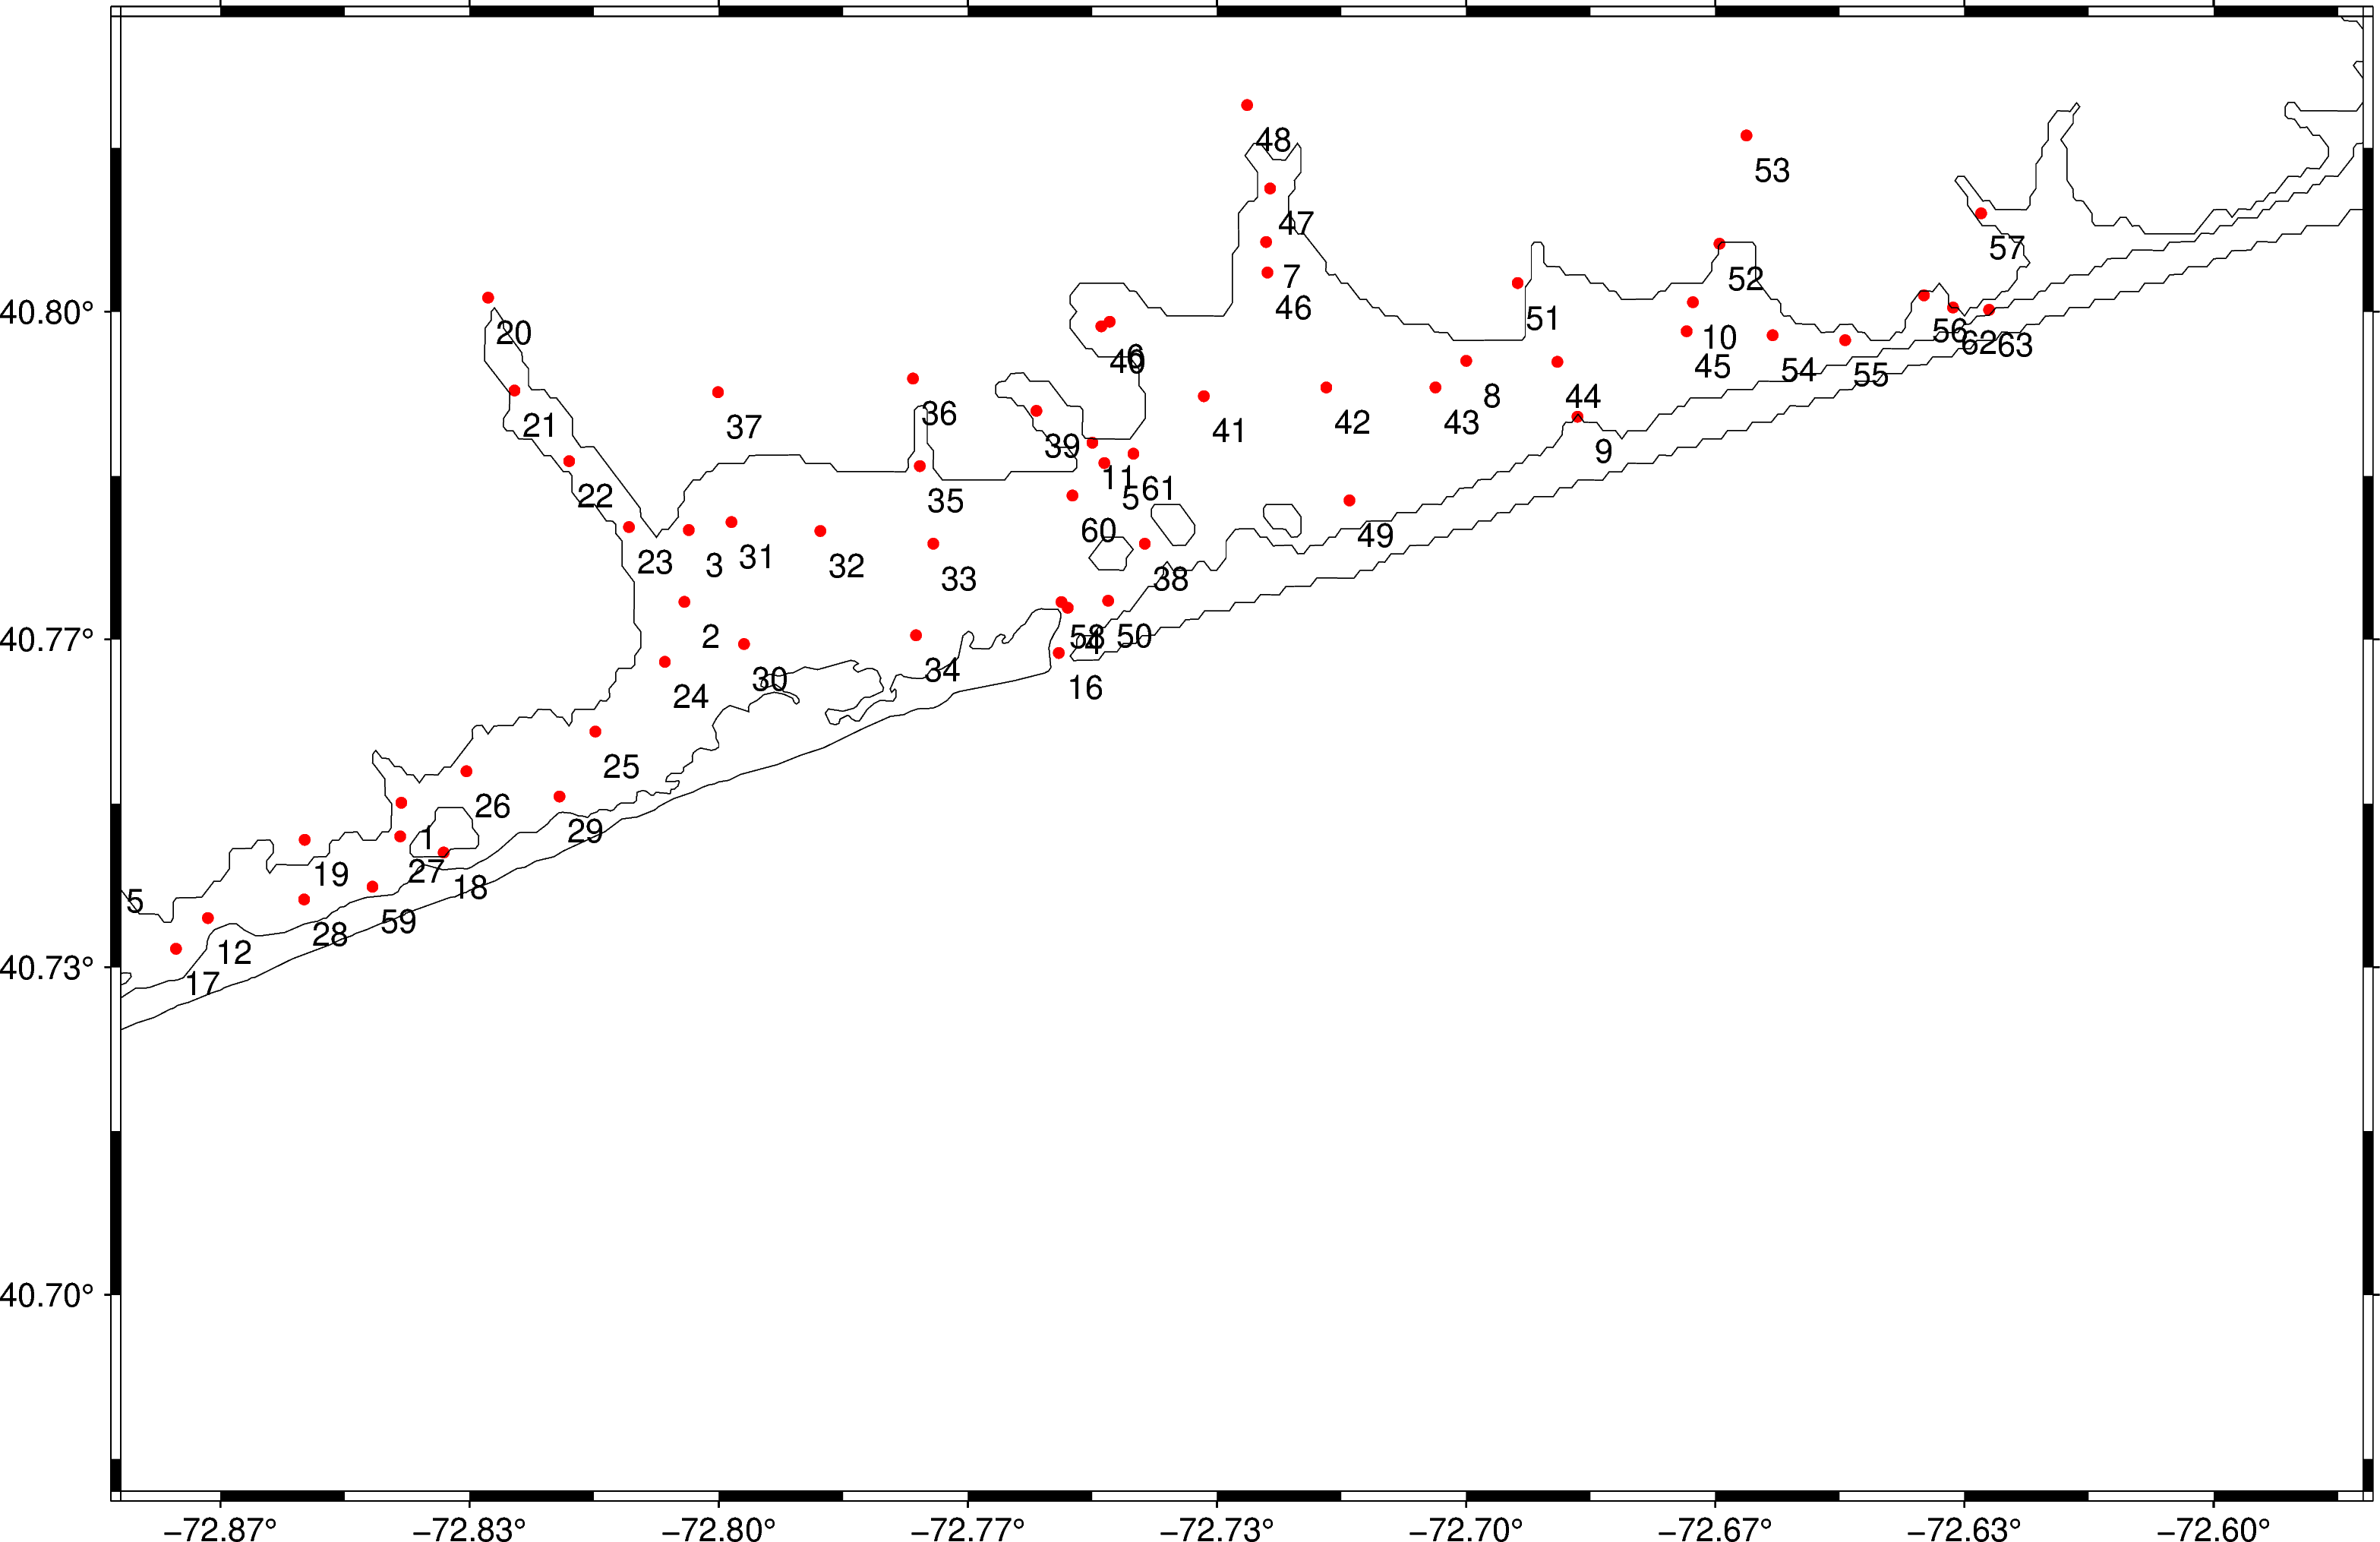

In [11]:
# ocean_g_df = pd.read_csv('/home/catherinej/BarrierBreach/src/visualization/ocean_gauges.csv', usecols=[1,2])
fig = pygmt.Figure()
grd = pygmt.datasets.load_earth_relief(region= [-72.88, -72.58, 40.68, 40.83],resolution='01s',)
with pygmt.config(
    FORMAT_GEO_MAP='ddd.xx'):
    fig.basemap(region=[-72.88, -72.58, 40.68, 40.83], projection='M25c', frame=True)

    fig.plot(x=bay_gauges.lon, y=bay_gauges.lat, color='red', style='c0.125c')
    # fig.plot(x=-72.875,y=40.73, color='blue', style='c0.25c')
    # fig.plot(x=-72.59, y=40.81, color='blue', style='c0.25c')
    fig.text(x=bay_gauges.lon+0.0035, y=bay_gauges.lat-0.0035, text=bay_gauges.index)
# fig.grdcontour(grid=grd, annotation=5, interval="-5,", D='5m_moriches.data', limit=[-6,-4], label_placement='D50k')
    # fig.plot(subset_df, color='orange', style='c0.25c')
    # fig.text(x=subset_df.lon, y=subset_df.lat-0.0035, text=subset_df.index)
    fig.coast(shorelines=True)
    fig.show()

In [13]:
bay_gauges[bay_gauges['Unnamed: 0'] == 67]

,Unnamed: 0,GaugeNames,lon,lat,depth,Distance,Location
17,67,67,-72.8726,40.7352,3.190144,37.38804,bay
